In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from IPython.display import clear_output

## 2-1: Dataset

In [ ]:
my_ID = 54
(f'I choose dataset number {my_ID%4}')

'I choose dataset number 2'

In [ ]:
# Normal dataset
!wget -q https://engineering.case.edu/sites/default/files/99.mat
# Faulty dataset
!wget -q https://engineering.case.edu/sites/default/files/107.mat

## 2-2: Working with dataset

In [ ]:
from scipy.io import loadmat

In [ ]:
# Loading normal data
data_n = loadmat('99.mat')
cols_n = list(data_n.keys())[-4:]

# Loading fault data
data_f = loadmat('107.mat')
cols_f = list(data_f.keys())[-4:-1]

In [ ]:
print(f"Data in normal dataset is:\n{cols_n}", end='\n\n')
print(f'Data in fault dataset is:\n{cols_f}')

Data in normal dataset is:
['X098_DE_time', 'X098_FE_time', 'X099_DE_time', 'X099_FE_time']

Data in fault dataset is:
['X107_DE_time', 'X107_FE_time', 'X107_BA_time']


### 2-2-1: Extracting data

In [ ]:
M = 250
N = 200
all_cols = np.concatenate((cols_n,cols_f))

matrices = dict()
for i in range(len(all_cols)):

    mat = np.zeros((M,N))
    for j in range(M):

        try:
            mat[j,:] = data_n[all_cols[i]][j:j+N].reshape(-1,)
        except:
            mat[j,:] = data_f[all_cols[i]][j:j+N].reshape(-1,)
    matrices[all_cols[i]] = mat

In [ ]:
for i,col in enumerate(all_cols):

    mat_size = matrices[col].shape
    print(f'Class "{col}"\'s matrix has the shape of {mat_size}')

Class "X098_DE_time"'s matrix has the shape of (250, 200)
Class "X098_FE_time"'s matrix has the shape of (250, 200)
Class "X099_DE_time"'s matrix has the shape of (250, 200)
Class "X099_FE_time"'s matrix has the shape of (250, 200)
Class "X107_DE_time"'s matrix has the shape of (250, 200)
Class "X107_FE_time"'s matrix has the shape of (250, 200)
Class "X107_BA_time"'s matrix has the shape of (250, 200)


In [ ]:
normal_mat = matrices['X099_DE_time']
fault_mat = matrices['X107_DE_time']

### 2-2-2: Feature extraction

In [ ]:
from scipy import stats

In [ ]:
class Features:

    def __init__(self,matrix):
        self.matrix = matrix
        self._extract()

    def _extract(self):

        self.features = {
            'standard deviation': stats.tstd(self.matrix, axis=1),
            'peak': np.max(self.matrix, axis=1),
            'skewness': stats.skew(self.matrix, axis=1),
            'mean': np.mean(self.matrix, axis=1),
            'absolute mean': np.mean(np.abs(self.matrix), axis=1),
            'root mean square': np.sqrt(np.mean(np.square(self.matrix), axis=1)),
            'square root mean': np.square(np.mean(np.sqrt(np.abs(self.matrix)), axis=1)),
            'kurtosis': stats.kurtosis(self.matrix, axis=1),
            'crest factor': np.max(self.matrix, axis=1) / np.sqrt(np.mean(np.square(self.matrix), axis=1)),
            'clearance factor': np.max(self.matrix, axis=1) / np.square(np.mean(np.sqrt(np.abs(self.matrix)), axis=1)),
            'peak to peak': np.max(self.matrix, axis=1) - np.min(self.matrix, axis=1),
            'shape factor': np.sqrt(np.mean(np.square(self.matrix), axis=1)) / np.mean(np.abs(self.matrix), axis=1),
            'impact factor': np.sqrt(np.mean(np.square(self.matrix), axis=1)) / np.mean(np.abs(self.matrix), axis=1),
            'impulse factor': np.abs(np.mean(self.matrix, axis=1)) / np.mean(np.abs(self.matrix), axis=1)
        }

    def __getitem__(self,key):
        return self.features[key]


normal_features = Features(normal_mat)
fault_features = Features(fault_mat)

In [ ]:
# Create dataframe for normal data ( Normal data label ---> 0 )
df_normal = pd.DataFrame(normal_features.features)
df_normal['label'] = np.zeros((df_normal.shape[0],), dtype='int8')
# Create dataframe for faulty data ( Fault data label --> 1 )
df_fault = pd.DataFrame(fault_features.features)
df_fault['label'] = np.ones((df_fault.shape[0],), dtype='int8')

# Stacking both datasets
df = pd.concat ([df_normal, df_fault], ignore_index=True)
df.head()

,standard deviation,peak,skewness,mean,absolute mean,root mean square,square root mean,kurtosis,crest factor,clearance factor,peak to peak,shape factor,impact factor,impulse factor,label
0,0.065162,0.179826,-0.102434,0.016275,0.051197,0.067005,0.041341,0.205579,2.683775,4.349826,0.355481,1.308760,1.308760,0.317890,0
1,0.065124,0.179826,-0.101089,0.016218,0.051140,0.066955,0.041293,0.211600,2.685784,4.354910,0.355481,1.309248,1.309248,0.317125,0
2,0.065046,0.179826,-0.095520,0.016050,0.050972,0.066839,0.041131,0.224659,2.690446,4.371997,0.355481,1.311286,1.311286,0.314875,0
3,0.065087,0.179826,-0.092039,0.015959,0.051063,0.066857,0.041302,0.216531,2.689711,4.353963,0.355481,1.309313,1.309313,0.312538,0
4,0.065158,0.179826,-0.091184,0.015882,0.051140,0.066907,0.041377,0.205829,2.687688,4.346023,0.355481,1.308321,1.308321,0.310557,0


### 2-2-3: Shuffling data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    df.drop('label', axis=1, inplace=False).values,
    df.label.values,
    test_size = 0.2,
    shuffle = True,
    random_state = 69
)
print(f'The split rate is: Train {len(y_train)/(len(y_train)+len(y_test))} & Test {len(y_test)/(len(y_train)+len(y_test))}')
print(f'Size of Train data is:\nX --> {x_train.shape}\ny --> {y_train.shape}')
print(f'Size of Test data is:\nX --> {x_test.shape}\ny --> {y_test.shape}')

The split rate is: Train 0.8 & Test 0.2
Size of Train data is:
X --> (400, 14)
y --> (400,)
Size of Test data is:
X --> (100, 14)
y --> (100,)


### 2-2-4: Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

## 2-3:  Logistic Regression from scratch

In [ ]:
class LogisticRegression:

    def __init__(self, n_iter=10, learning_rate=0.01, random_state=None):
        self.n_iter = n_iter
        self.eta = learning_rate
        np.random.seed(random_state)

    def _weight_init(self):
        self.w = np.random.rand(14)*0
        self.b = np.random.rand()

    def _update(self,x,E):
        dj = np.dot(x.T,E)
        self.w += self.eta*dj
        self.b += self.eta*np.sum(E)

    def forward(self,x):
        z = np.dot(x,self.w) + self.b
        a = 1/(1+np.e**(-z))
        y_hat = np.array([1 if hat>.5 else 0 for hat in a])
        return y_hat

    def error(self,predict,true):
        E = true - predict
        e = 1/len(true) * np.dot(E,E)
        return E,e

    def train(self,x,y):
        self._weight_init()
        self.loss = []
        for iter in range(self.n_iter):

            y_hat = self.forward(x)
            E,e = self.error(y_hat,y)
            self.loss.append(e)
            self._update(x,E)

# Train model with data
model = LogisticRegression(
    n_iter = 100,
    learning_rate =0.0001,
    random_state = 25
)
model.train(x_train_scaled,y_train)


Text(0.5, 0, 'Iteration')

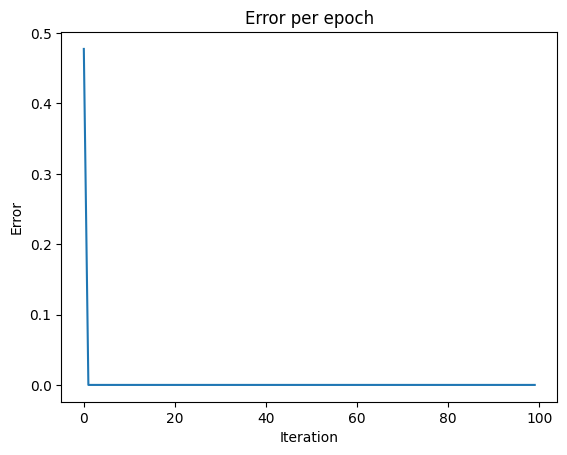

In [ ]:
# Plot loss
plt.plot(model.loss)
plt.title('Error per epoch')
plt.ylabel('Error')
plt.xlabel('Iteration')

Evaluating the trained model

In [ ]:
# Predict test values
y_hat = model.forward(x_test_scaled)

# Confusion matrix
TP = np.sum(y_hat[y_test==1])
TN = np.sum(np.abs(y_hat[y_test==0]-1))
FP = np.sum(y_hat[y_test==0])
FN = np.sum(np.abs(y_hat[y_test==1]-1))

# Accuracy
accuracy = (TP+TN)/len(y_test)
print(f'Accuracy on test data is {accuracy*100:.1f}%')

# F1-score
precision = TP / (TP+FP)
recall = TP / (TP+FN)
f1_score = 2 * (precision*recall)   /(precision+recall)
print(f'F1-score on test data is {f1_score*100:.1f}% ')



Accuracy on test data is 100.0%
F1-score on test data is 100.0% 


## 2-4: scikit-learn model

In [ ]:
from sklearn.linear_model import SGDClassifier

class SGDwithLoss(SGDClassifier):
    def __init__(self):
        super().__init__()
        self.loss_history = []

    def partial_fit(self, X, y, classes=None, sample_weight=None):

        super().partial_fit(X, y, classes=classes, sample_weight=sample_weight)
        y_hat  = self.predict(X)
        error =  y_hat-y
        loss = 1/len(y) *  np.dot(error,error)
        self.loss_history.append(loss)

Text(0.5, 0, 'Iteration')

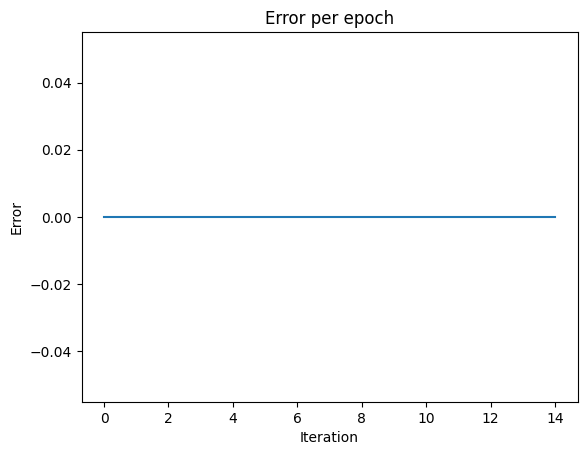

In [ ]:
sgd_model = SGDwithLoss()

# Train model partialy
N_ITERATION = 15
sgd_loss = []
for i in range(N_ITERATION):

    sgd_model.partial_fit(x_train_scaled,y_train, classes=np.unique(y_train))
plt.plot(sgd_model.loss_history)

plt.title('Error per epoch')
plt.ylabel('Error')
plt.xlabel('Iteration')

In [ ]:
# Predict test values
y_hat = sgd_model.predict(x_test_scaled)

# Confusion matrix
TP = np.sum(y_hat[y_test==1])
TN = np.sum(np.abs(y_hat[y_test==0]-1))
FP = np.sum(y_hat[y_test==0])
FN = np.sum(np.abs(y_hat[y_test==1]-1))

# Accuracy
accuracy = (TP+TN)/len(y_test)
print(f'Accuracy on test data is {accuracy*100:.1f}%')

# F1-score
precision = TP / (TP+FP)
recall = TP / (TP+FN)
f1_score = 2 * (precision*recall)   /(precision+recall)
print(f'F1-score on test data is {f1_score*100:.1f}% ')



Accuracy on test data is 100.0%
F1-score on test data is 100.0% 


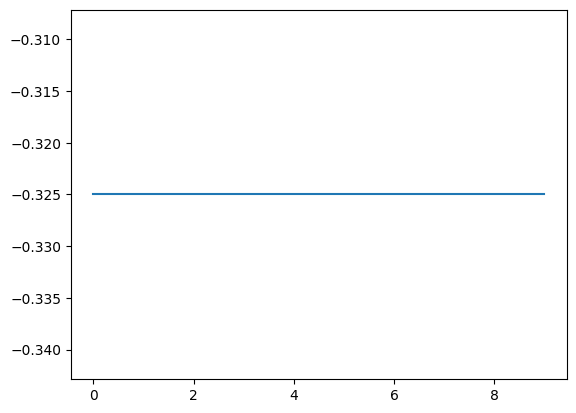